(4990, 50, 3)
Loaded quark and gluon jets
[[ 2.68769142e-01  3.56903171e-01  4.74138734e+00]
 [ 1.60076377e-01 -2.55609533e-01  4.55022910e+00]
 [ 1.14868731e+00 -6.24380156e-02  4.50385377e+00]
 [ 4.13159146e+00  1.73686350e-01  4.76622410e+00]
 [ 1.69599701e+00 -2.12177764e-01  4.79687162e+00]
 [ 2.19372581e+00 -5.24780791e-02  4.57559636e+00]
 [ 1.61909680e+00 -6.76247614e-02  4.64561192e+00]
 [ 6.59214883e+00  4.42691311e-02  4.76597141e+00]
 [ 3.77096258e+00  4.22475280e-02  4.75473207e+00]
 [ 1.34816345e+01 -2.80005472e-02  4.73543183e+00]
 [ 4.10794493e+00 -2.37648715e-02  4.75891312e+00]
 [ 2.16455176e+01 -2.69973695e-02  4.75997450e+00]
 [ 6.77551168e+00 -2.97549224e-02  4.76127746e+00]
 [ 1.32550803e+01 -3.94389998e-02  4.74948328e+00]
 [ 2.98350842e+00 -3.66033986e-02  4.74619579e+00]
 [ 3.73743866e+01 -3.54428448e-02  4.75481319e+00]
 [ 3.35399046e+02 -3.25602518e-02  4.75085918e+00]
 [ 4.42135649e+01 -3.32763050e-02  4.75431907e+00]
 [ 0.00000000e+00  0.00000000e+00  0.000

Train on 4000 samples, validate on 500 samples
Epoch 1/5
4000/4000 [==============================] - 1s 285us/step - loss: 0.6730 - acc: 0.5373 - val_loss: 0.6518 - val_acc: 0.6640
Epoch 2/5
4000/4000 [==============================] - 0s 18us/step - loss: 0.6446 - acc: 0.6900 - val_loss: 0.6322 - val_acc: 0.6800
Epoch 3/5
4000/4000 [==============================] - 0s 19us/step - loss: 0.6235 - acc: 0.6933 - val_loss: 0.6054 - val_acc: 0.6940
Epoch 4/5
4000/4000 [==============================] - 0s 18us/step - loss: 0.5975 - acc: 0.6925 - val_loss: 0.5859 - val_acc: 0.6800
Epoch 5/5
4000/4000 [==============================] - 0s 17us/step - loss: 0.5801 - acc: 0.6943 - val_loss: 0.5741 - val_acc: 0.6740

EFN AUC: 0.7687741763372014



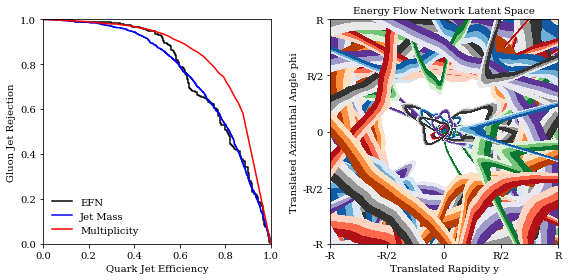

In [20]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 4000, 500, 490
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

###############################################################################

# load data
X, y = qg_jets.load(train + val + test)

# ignore pid information
X = X[:4990,:50,:3]
Y = Y[:4990]
print(X.shape)
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for i in range(len(X)):
    x = X[i]
    if i == 0 or i == 1:
        print(x)
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
efn.fit([z_train, p_train], Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=([z_val, p_val], Y_val),
          verbose=1)

# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('EFN AUC:', auc)
    print()

    # make ROC curve and filter plot if we have matplotlib
    if plt:

        # some nicer plot settings 
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        fig, axes = plt.subplots(1, 2, figsize=(8,4))

        ######################### ROC Curve Plot #########################

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # plot the ROC curves
        axes[0].plot(efn_tp, 1-efn_fp, '-', color='black', label='EFN')
        axes[0].plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        axes[0].plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        axes[0].set_xlabel('Quark Jet Efficiency')
        axes[0].set_ylabel('Gluon Jet Rejection')

        # axes limits
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(0, 1)

        # make legend and show plot
        axes[0].legend(loc='lower left', frameon=False)

        ######################### Filter Plot #########################

        # plot settings
        R, n = 0.4, 100
        colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
        grads = np.linspace(0.45, 0.55, 4)

        # evaluate filters
        X, Y, Z = efn.eval_filters(R, n=n)

        # plot filters
        for i,z in enumerate(Z):
            axes[1].contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])

        axes[1].set_xticks(np.linspace(-R, R, 5))
        axes[1].set_yticks(np.linspace(-R, R, 5))
        axes[1].set_xticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
        axes[1].set_yticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
        axes[1].set_xlabel('Translated Rapidity y')
        axes[1].set_ylabel('Translated Azimuthal Angle phi')
        axes[1].set_title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})

        plt.show()

In [2]:
X

array([[-0.4       , -0.4       , -0.4       , ..., -0.4       ,
        -0.4       , -0.4       ],
       [-0.39191919, -0.39191919, -0.39191919, ..., -0.39191919,
        -0.39191919, -0.39191919],
       [-0.38383838, -0.38383838, -0.38383838, ..., -0.38383838,
        -0.38383838, -0.38383838],
       ...,
       [ 0.38383838,  0.38383838,  0.38383838, ...,  0.38383838,
         0.38383838,  0.38383838],
       [ 0.39191919,  0.39191919,  0.39191919, ...,  0.39191919,
         0.39191919,  0.39191919],
       [ 0.4       ,  0.4       ,  0.4       , ...,  0.4       ,
         0.4       ,  0.4       ]])

In [3]:
y

array([1., 1., 1., ..., 1., 0., 0.])

In [4]:
X.shape

(100, 100)

In [6]:
len(qg_jets.load(train + val + test))

2

In [10]:
x,y = qg_jets.load(train + val + test)

In [11]:
x.shape

(100000, 139, 4)

In [12]:
y.shape

(100000,)

In [13]:
y

array([1., 1., 1., ..., 1., 0., 0.])

(array([50000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 50000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

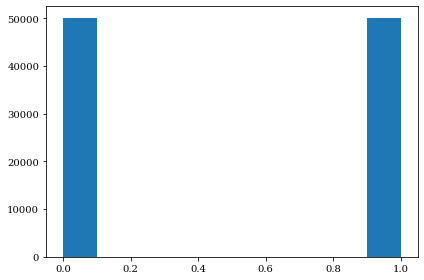

In [14]:
plt.hist(y)

In [15]:
x

array([[[ 2.68769142e-01,  3.56903171e-01,  4.74138734e+00,
          2.20000000e+01],
        [ 1.60076377e-01, -2.55609533e-01,  4.55022910e+00,
          2.20000000e+01],
        [ 1.14868731e+00, -6.24380156e-02,  4.50385377e+00,
         -2.11000000e+02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 1.21266321e+00, -1.12853089e-01,  3.04708757e+00,
         -2.11000000e+02],
        [ 2.40893976e-01, -1.67174886e-02,  2.82705667e+00,
          2.20000000e+01],
        [ 1.02778452e-01, -8.58720522e-02,  3.04180579e+00,
          2.20000000e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.000